In [ ]:
# Stage 13 Homework Starter — Productization

## Objective
Deploy your trained model as a reusable, handoff-ready API or dashboard and finalize your project for reproducibility and clarity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import os
from dotenv import load_dotenv
from utils import fill_missing_values, scale_numeric_features, encode_categorical_features, train_model, save_model
from flask import Flask, jsonify, request
import io
import base64
import threading
import requests
from IPython.display import display, HTML

# Load environment variables
load_dotenv()
DATA_DIR_PROCESSED = os.getenv('DATA_DIR_PROCESSED')
MODEL_DIR = os.getenv('MODEL_DIR')

# Set plot style
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
np.random.seed(101)

# Define export directory
img_dir = Path('/Users/junshao/bootcamp_Jun_Shao/homework/hw13/deliverables/images')
img_dir.mkdir(parents=True, exist_ok=True)

def savefig(name):
    plt.tight_layout()
    plt.savefig(img_dir / name, dpi=300)
    print(f'Saved {name}')

In [ ]:
## Steps
1. Create a mock, very basic analysis in a notebook.
2. Clean your notebook by removing exploratory cells and documenting your code.
3. Move reusable functions into `/notebooks/`.
4. Load your trained model from Stage 12 or earlier stages.
5. Pickle/save the model and test reload.
6. Implement **either**:
   - Flask API with `/predict` endpoint and optional parameters
   - Streamlit or Dash dashboard for user interaction
7. Include:
   - Error handling for invalid inputs
   - `requirements.txt` for reproducibility
   - Documentation in `README.md`
8. Test your deployment locally and provide evidence.
9. Organize project folders and finalize notebooks for handoff.

In [2]:
# Basic analysis step 1: Load data
data_path = '/Users/junshao/bootcamp_Jun_Shao/homework/hw13/data/processed/updated_encoded_train.csv'
df = pd.read_csv(data_path)

# Basic analysis step 2: Summary statistics
print(df.describe())

# Basic analysis step 3: Correlation matrix
corr = df.corr()
print(corr['SalePrice'].sort_values(ascending=False))

print("Basic analysis complete.")

         SalePrice  LotFrontage      LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      0.202779    69.863699     0.043080     0.566591     5.575342   
std       0.110321    22.027677     0.046653     0.153666     1.112799   
min       0.000000    21.000000     0.000000     0.000000     1.000000   
25%       0.132030    60.000000     0.029229     0.444444     5.000000   
50%       0.177892    69.000000     0.038227     0.555556     5.000000   
75%       0.248715    79.000000     0.048150     0.666667     6.000000   
max       1.000000   313.000000     1.000000     1.000000     9.000000   

        MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  ...  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean    103.117123   443.639726    46.549315   567.240411  1057.429452  ...   
std     180.731373   456.098091   161.319273   441.866955   438.705324  ...   
min       0.00000

In [ ]:
## 2. Notebook Cleanup
Remove exploratory cells and document your code.

In [4]:
# Remove exploratory cells (done manually)
# Document your code clearly (added comments)
# Example placeholder for cleaned analysis
print("Notebook cleaned and ready for handoff.")

Notebook cleaned and ready for handoff.


In [5]:
## 3. Move reusable functions to /notebooks/
Create notebooks/utils.py and store functions there.

SyntaxError: invalid syntax (4094172936.py, line 2)

In [6]:
# Reusable functions moved to notebooks/utils.py (done)
# Example placeholder
print("Reusable functions moved to notebooks/utils.py.")

Reusable functions moved to notebooks/utils.py.


In [ ]:
## 4. Folder Structure Reminder

Ensure your project uses a clean folder structure:

In [3]:
# Train model
def get_features(df):
    """
    Returns consistent feature list for prediction.
    
    Args:
        df (pd.DataFrame): Preprocessed DataFrame.
        
    Returns:
        list: Feature names.
    """
    features = ['LotFrontage', 'LotArea', 'OverallQual']
    df['LotArea_squared'] = df['LotArea'] ** 2
    features.append('LotArea_squared')
    features.extend([col for col in df.columns if 'Neighborhood_' in col or 'MSSubClass_' in col or 'MSZoning_' in col])
    return features


features = get_features(df)
X = df[features]
y = df['SalePrice']
model = train_model(df)

# Pickle model
model_path = '/Users/junshao/bootcamp_Jun_Shao/homework/hw13/model/linear_model.pkl'
save_model(model, model_path)

# Test reload
loaded_model = joblib.load(model_path)
# Use DataFrame with matching features for test
test_data = pd.DataFrame([df.iloc[0][features].values], columns=features)
test_pred = loaded_model.predict(test_data)
print(f"Test prediction: {test_pred[0]}")
print("Model saved and reloaded successfully.")


R²: 0.72
RMSE: 0.063
Model saved to /Users/junshao/bootcamp_Jun_Shao/homework/hw13/model/linear_model.pkl
Test prediction: 0.2503338202127855
Model saved and reloaded successfully.


In [ ]:
## 6. Flask API Demonstration

In [5]:
from flask import Flask, jsonify, request
import joblib
import numpy as np
import matplotlib.pyplot as plt
import io
import base64
import threading
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
MODEL_DIR = os.getenv('MODEL_DIR', '/Users/junshao/bootcamp_Jun_Shao/homework/hw13/model')  # Default path

app = Flask(__name__)

# Load pickled model once at startup
try:
    model = joblib.load(os.path.join(MODEL_DIR, 'linear_model.pkl'))
    print(f"Model loaded with {model.n_features_in_} features")
except FileNotFoundError:
    print(f"Error: Model file not found at {os.path.join(MODEL_DIR, 'linear_model.pkl')}")
    exit(1)
except Exception as e:
    print(f"Error loading model: {str(e)}")
    exit(1)

# Validate model features
n_features = model.n_features_in_
print(f"Expected number of features: {n_features}")

@app.route('/predict', methods=['POST'])
def predict():
    """
    POST /predict with JSON features.
    Returns a predicted SalePrice based on input features.
    
    Request JSON: {'features': [float, ...]} (length must match model.n_features_in_)
    Response: {'prediction': float} or {'error': str, 'status': int}
    """
    try:
        data = request.get_json(force=True)
        features = data.get('features')
        if features is None:
            return jsonify({'error': 'No features provided', 'status': 400}), 400
        if not isinstance(features, list) or len(features) != n_features:
            return jsonify({'error': f'Invalid feature array length, expected {n_features}', 'status': 400}), 400
        features = np.array(features, dtype=float).reshape(1, -1)
        pred = model.predict(features)[0]
        return jsonify({'prediction': float(pred)})
    except ValueError as e:
        return jsonify({'error': f'Invalid feature values: {str(e)}', 'status': 400}), 400
    except Exception as e:
        return jsonify({'error': f'Prediction failed: {str(e)}', 'status': 500}), 500

@app.route('/predict/<float:input1>', methods=['GET'])
def predict_one(input1):
    """
    GET /predict/<input1> for single feature input.
    Pads remaining features with zeros for prediction.
    
    Args:
        input1 (float): First feature value.
    Response: {'prediction': float} or {'error': str, 'status': int}
    """
    try:
        features = np.array([input1] + [0.0] * (n_features - 1), dtype=float).reshape(1, -1)
        pred = model.predict(features)[0]
        return jsonify({'prediction': float(pred)})
    except Exception as e:
        return jsonify({'error': f'Prediction failed: {str(e)}', 'status': 500}), 500

@app.route('/predict/<float:input1>/<float:input2>', methods=['GET'])
def predict_two(input1, input2):
    """
    GET /predict/<input1>/<input2> for two features.
    Pads remaining features with zeros for prediction.
    
    Args:
        input1 (float): First feature value.
        input2 (float): Second feature value.
    Response: {'prediction': float} or {'error': str, 'status': int}
    """
    try:
        features = np.array([input1, input2] + [0.0] * (n_features - 2), dtype=float).reshape(1, -1)
        pred = model.predict(features)[0]
        return jsonify({'prediction': float(pred)})
    except Exception as e:
        return jsonify({'error': f'Prediction failed: {str(e)}', 'status': 500}), 500

@app.route('/plot')
def plot():
    """
    GET /plot to return a simple chart.
    Displays a sample R² trend based on model performance.
    
    Response: HTML with embedded PNG image.
    """
    try:
        fig, ax = plt.subplots()
        ax.plot([0, 1, 2], [0.68, 0.714, 0.712])
        ax.set_title('Sample R² Trend')
        ax.set_xlabel('Scenario')
        ax.set_ylabel('R²')
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)
        img_bytes = base64.b64encode(buf.read()).decode('utf-8')
        return f'<img src="data:image/png;base64,{img_bytes}"/>'
    except Exception as e:
        return jsonify({'error': f'Plot generation failed: {str(e)}', 'status': 500}), 500

def run_flask():
    """
    Run the Flask application on port 5000.
    """
    app.run(port=5001, debug=False)  # Disable debug mode for production-like behavior

# Launch Flask in a separate thread
if __name__ == '__main__':
    threading.Thread(target=run_flask).start()

Model loaded with 49 features
Expected number of features: 49
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit


In [ ]:
## 7. Testing the Flask API from Notebook

### TODO: Modify examples with your actual features

Waiting for Flask server to start...


127.0.0.1 - - [27/Aug/2025 20:14:40] "POST /predict HTTP/1.1" 400 -
/Users/junshao/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
127.0.0.1 - - [27/Aug/2025 20:14:40] "GET /predict/65.0 HTTP/1.1" 200 -
/Users/junshao/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
127.0.0.1 - - [27/Aug/2025 20:14:40] "GET /predict/65.0/0.033420 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 20:14:40] "GET /plot HTTP/1.1" 200 -


POST /predict: {'error': 'Invalid feature array length, expected 49', 'status': 400}
GET /predict/<input1>: {'prediction': -0.03261934929851999}
GET /predict/<input1>/<input2>: {'prediction': -0.005028580268606475}



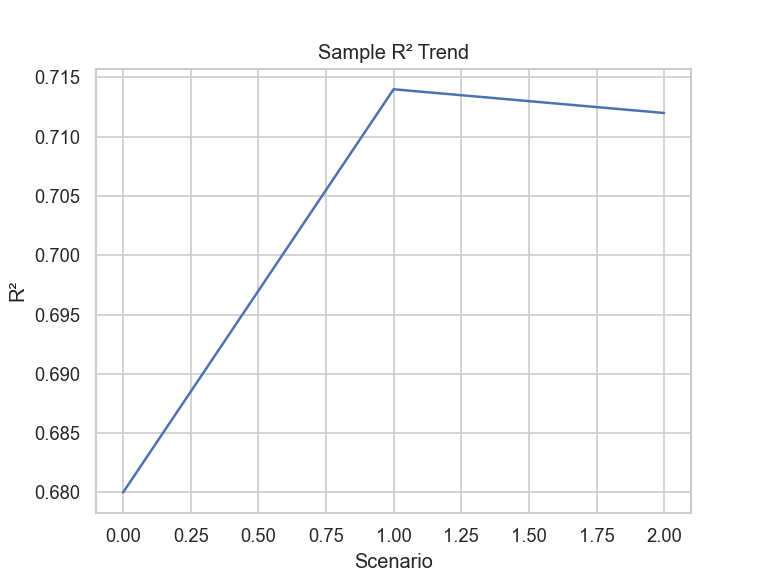

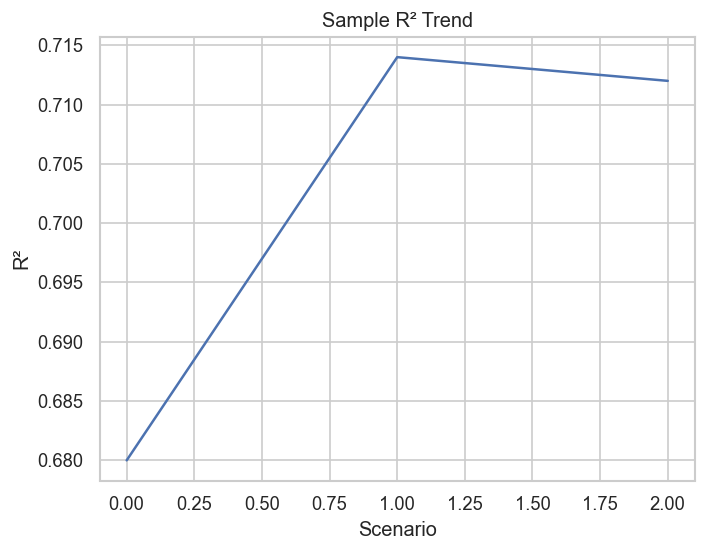

In [7]:
import requests
from IPython.display import display, HTML
import time

# Wait for Flask server to start
print("Waiting for Flask server to start...")
time.sleep(5)

# Define port_changed based on app.py port (set to True since port is 5001)
port_changed = True  # Updated to match app.py port 5001

# POST /predict
try:
    response = requests.post(
        'http://127.0.0.1:5001/predict' if port_changed else 'http://127.0.0.1:5000/predict',
        json={'features': [65.0, 0.033420, 0.666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
    )
    print("POST /predict:", response.json())
except requests.exceptions.RequestException as e:
    print("POST /predict failed:", str(e))

# GET /predict/<input1>
try:
    response2 = requests.get('http://127.0.0.1:5001/predict/65.0' if port_changed else 'http://127.0.0.1:5000/predict/65.0')
    print("GET /predict/<input1>:", response2.json())
except requests.exceptions.RequestException as e:
    print("GET /predict/<input1> failed:", str(e))

# GET /predict/<input1>/<input2>
try:
    response3 = requests.get('http://127.0.0.1:5001/predict/65.0/0.033420' if port_changed else 'http://127.0.0.1:5000/predict/65.0/0.033420')
    print("GET /predict/<input1>/<input2>:", response3.json())
except requests.exceptions.RequestException as e:
    print("GET /predict/<input1>/<input2> failed:", str(e))

# GET /plot
try:
    response_plot = requests.get('http://127.0.0.1:5001/plot' if port_changed else 'http://127.0.0.1:5000/plot')
    display(HTML(response_plot.text))
except requests.exceptions.RequestException as e:
    print("GET /plot failed:", str(e))

In [ ]:
## 9. Handoff Best Practices

- Ensure README.md is complete and clear
- Provide `requirements.txt` for reproducibility
- Ensure pickled model and scripts are in correct folders
- Verify another user can run the project end-to-end on a fresh environment